## **MIXED-INTEGER PROGRAMMING MODEL FOR THE AIRPLANE LANDING PROBLEM**

# Installing the Google OR-Tools library:

In [ ]:
# instal Google OR Tools library
#pip install --upgrade --user ortools
!pip install ortools

# Importing all the libraries:

In [ ]:
# import libraries
import ortools.linear_solver
from ortools.linear_solver import pywraplp

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as plt
%matplotlib inline

# Importing the file (only needed when using Google Colab):

In [ ]:
# necessary to import the "csv transformados" files

import io
from google.colab import files
uploaded = files.upload()

Saving airland13.csv to airland13.csv


# Instancing the data file:

In [ ]:
# instancing one of the 13 files (use one at a time)

data = pd.read_csv('airland13.csv', delimiter=';', header=None)

In [ ]:
data_print = data
data_print = data.rename(index={0: "Nplanes; Ftime"})
data_print = data.rename(columns={0: "Atime", 1: "E", 2:"T", 3:"L", 4:"CA", 5:"CB"})
P = int(data.iloc[0][0]) # P is the number of planes

for i in range(P):
 data_print = data_print.rename(columns={(6+i): "P%d" %(i+1)})
data_print

,Atime,E,T,L,CA,CB,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,...,P461,P462,P463,P464,P465,P466,P467,P468,P469,P470,P471,P472,P473,P474,P475,P476,P477,P478,P479,P480,P481,P482,P483,P484,P485,P486,P487,P488,P489,P490,P491,P492,P493,P494,P495,P496,P497,P498,P499,P500
0,500,720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,601,709.0,2401.0,1.70,1.90,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
2,420,1020,1298.0,2820.0,1.19,1.27,113.0,90.0,113.0,90.0,113.0,113.0,113.0,90.0,90.0,113.0,135.0,113.0,135.0,113.0,90.0,90.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,135.0,90.0,135.0,90.0,90.0,90.0,113.0,113.0,90.0,90.0,...,113.0,135.0,113.0,113.0,90.0,90.0,90.0,113.0,90.0,90.0,90.0,90.0,90.0,113.0,90.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,90.0,113.0,90.0,90.0,113.0,90.0,90.0,90.0,113.0,135.0,113.0,113.0,113.0,113.0,135.0,113.0
3,429,1029,1574.0,2829.0,1.13,1.88,90.0,68.0,68.0,68.0,90.0,68.0,90.0,68.0,68.0,68.0,90.0,68.0,90.0,68.0,68.0,68.0,90.0,90.0,68.0,68.0,90.0,68.0,90.0,90.0,90.0,68.0,90.0,68.0,68.0,68.0,90.0,90.0,68.0,68.0,...,68.0,90.0,90.0,90.0,68.0,68.0,68.0,90.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,90.0,68.0,90.0,68.0,68.0,90.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,90.0,90.0,68.0,90.0,90.0,68.0,90.0,68.0
4,493,1093,1504.0,2893.0,1.86,1.14,113.0,90.0,113.0,90.0,113.0,113.0,113.0,90.0,90.0,113.0,135.0,113.0,135.0,113.0,90.0,90.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,135.0,90.0,135.0,90.0,90.0,90.0,113.0,113.0,90.0,90.0,...,113.0,135.0,113.0,113.0,90.0,90.0,90.0,113.0,90.0,90.0,90.0,90.0,90.0,113.0,90.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,90.0,113.0,90.0,90.0,113.0,90.0,90.0,90.0,113.0,135.0,113.0,113.0,113.0,113.0,135.0,113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,53586,54186,54699.0,55986.0,1.33,1.96,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
497,53604,54204,54769.0,56004.0,1.32,1.21,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
498,53636,54236,54734.0,56036.0,1.75,1.95,90.0,68.0,68.0,68.0,90.0,68.0,90.0,68.0,68.0,68.0,90.0,68.0,90.0,68.0,68.0,68.0,90.0,90.0,68.0,68.0,90.0,68.0,90.0,90.0,90.0,68.0,90.0,68.0,68.0,68.0,90.0,90.0,68.0,68.0,...,68.0,90.0,90.0,90.0,68.0,68.0,68.0,90.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,90.0,68.0,90.0,68.0,68.0,90.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,90.0,90.0,68.0,90.0,90.0,68.0,90.0,68.0
499,53701,54301,54416.

(except line 0)

Column 0: **Atime** -> the time by which the plane i has appeared

Column 1: **E** -> the earliest landing time for plane

Column 2: **T** -> the target landing time for plane i

Column 3: **L** -> the latest landing time for plane i

Column 4: **CB** -> the penalty cost per unit of time for airplane i landing before target

Column 5: **CA** -> the penalty cost per unit of time for airplane i landing after target

Column 6 .. P+5: **Stimes** ->  Stimes is the required separation time between plane i landing and plane j landing 









# Instancing the constants/coefficients of the data file as script variables:

In [ ]:
P = int(data.iloc[0][0]) # P is the number of planes
Ftime = data.iloc[0][1] # Ftime is the freeze time

airplanes = []

for i in range(1, len(data)): # 1<= i <= 10
  airplane = data.iloc[i]
  airplanes.append([airplane])

Stimes = [] # Stimes is the required separation time between plane i landing and plane j landing (where plane i lands before plane j -- i=1,...,P and j=1,...,P)
Atime = [] # Atime is the time by which the plane i has appeared // Column 0 (except line 0)
E = [] # E is the earliest landing time for plane i (i=1,...,P)
T = [] # T is the target landing time for plane i (i=1,...,P)
L = [] # L is the latest landing time for plane i (i=1,...,P)
CB = [] # CB is the penalty cost per unit of time for airplane i landing before target
CA =[] # CA is the penalty cost per unit of time for airplane i landing after target

for i in range(P):
  Stimes.append([airplanes[i][0][6:].values]) #plane 1 has index 0 - separation time required after i lands before others j can land: times[i][0][j]
  Atime.append([airplanes[i][0][0]])
  E.append(airplanes[i][0][1]) 
  T.append(airplanes[i][0][2])  
  L.append(airplanes[i][0][3])
  CB.append(airplanes[i][0][4]) 
  CA.append(airplanes[i][0][5])

# Creates a list containing P lists, each of P items, all set to NaN:
w, h = P, P
S = [[np.nan for x in range(w)] for y in range(h)] # same structure as Stimes
Stimes = np.array(Stimes)
for i in range(P):
  for j in range(P):
    S[i][j] = int(Stimes[i][0][j]) # S is a matrix (list os lists) with the required separation time between plane i landing and plane j landing

# Time window (earliest-latest landing time) for each plane:

<function matplotlib.pyplot.show>

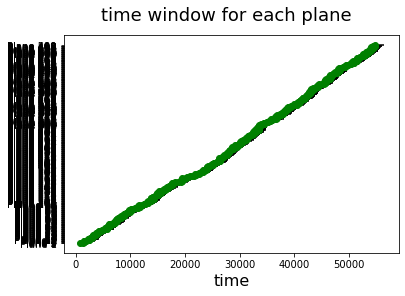

In [ ]:
import matplotlib.pyplot as pltp

fig, ax = pltp.subplots()
for i in range(P):
  ax.hlines(y="Plane %d"%(i+1), xmin=E[i], xmax=L[i])
  pltp.plot(T[i], i, 'go')
fig.suptitle('time window for each plane', fontsize=18)
pltp.xlabel('time', fontsize=16)
pltp.show

# Declaring the SCIP-MIP solver 

In [ ]:
# declaring the SCIP (is a type of MIP (integer solver))

solver = pywraplp.Solver.CreateSolver('SCIP')

# Defining the decision variables of the problem: 

**The decision variables are:**

xi = the landing time for plane i (i=1,...,P)

αi = how soon plane i (i=1,...,P) lands before Ti

      If plane i lands after Ti then αi = 0

βi = how soon plane i (i=1,...,P) lands after Ti

      If plane i lands before Ti then βi = 0

δij = 1 if plane i lands before plane j (i=1,...,P; j=1,...,P)

= 0 otherwise

    Every line on δij has just one value iquals to 1 (all the rest are zeros), exept one of the lines (that represents the 1st plane to land) 

**We will assume that all times are integers.**

In [ ]:
# creating the variables

infinity = solver.infinity()

x = [0 for x in range(P)]
alpha = [0 for x in range(P)]
beta = [0 for x in range(P)]

delta = [[np.nan for x in range(P)] for y in range(P)]

for i in range(P): 
  x[i] = solver.IntVar(0, infinity, "x%i" %(i)) # landing time vector for all planes
  alpha[i] = solver.IntVar(0, infinity, "alpha%i" %(i)) # vector which contains how soon each plane lands before its target time
  beta[i] = solver.IntVar(0, infinity, "beta%i" %(i)) # vector which contains how soon each plane lands after its target time
  
  for j in range(P):
    delta[i][j] = solver.BoolVar("delta%d%d" %(i,j)) # boolean matrix which contains the info if plane i lands before j (=1) or not (=0)

# Constraints for the MIP solution of the airplane landing problem with single runway and static state/mode:

**Constraints for LP problem with single runway:**

The following are the minimum and basic constraints that should be guaranteed so then the problem is solved. However, in any particular situation there may be necessary to add restrictions, that can easily be incorporated to the previus model.


## **C1**

To ensure that each plane lands within its time window:

E[i] <= xi <= L[i], where i=1,...,P

- E[i] is the earliest landing time for plane i
- xi is the landing time for plane i
- L[i] is the latest landing time for plane i

In [ ]:
# constraint 1: E[i] <= xi <= L[i], where i=1,...,P
for i in range(P):
  solver.Add(x[i] >= E[i])
  solver.Add(x[i] <= L[i])

## **C2**

If plane i lands before j then j cannot land before i and vice-versa:

δij + δji = 1, where i=1,...,P and j=1,...,P for j>i




In [ ]:
# constraint 2: δij + δji = 1, where i=1,...,P and j=1,...,P for j>i
#for i in range(P):
#  for j in range(P):
#    if j > i:
#    #solver.Add(delta[i][j] + delta[j][i] == 1)
#      if (delta[i][j]==0):
#          solver.Add(delta[j][i]==1)
#      
#      elif (delta[i][j]==1):
#          solver.Add(delta[j][i]==0)
#      else:
#          pass
#    else:
#          pass

In [ ]:
# constraint 2: δij + δji = 1, where i=1,...,P and j=1,...,P for j>i
for i in range(P):
  for j in range(P):
    if j > i:
      solver.Add(delta[i][j] + delta[j][i] == 1)
      
    else:
          pass

       - Deffinitions for the next constraints:

       There are three cases can happen:

        - **:**
       If considering the time windows for i and j the separation constraint is , knowing that the time window for plane i occurs before the time window for plane j. That is, if the smallest time difference between the time window for plane i and the time window for plane j is  >= the separation time for there planes (Li+Sij≤Ej). Then SA is the set of pairs (i,j) of these planes and:

       SA=[(i,j) Li<Ej and Li+Sij≤Ej i=1,...,P; j=1,...,P; i != j]
       => (xi < xj) AND (xi + Sij < xj)
       SA => *Satisfied Automatically*
  
       -**:**
       If considering the time windows for i and j the separation constraint is *NOT automatically satisfied*, knowing that the time window for plane i occurs before the time window for plane j. That is, if the smallest time difference between the time window for plane i and the time window for plane j is  < the separation time for there planes (Li+Si>Ej). Then SNA is the set of pairs (i,j) of these planes and:

       SNA=[(i,j) Li<Ej and Li+Sij>Ej i=1,...,P; j=1,...,P; i != j]

       (xi < xj) BUT (xi + Sij < xj) OR (xi + Sij > xj)

      SNA => *Satisfied NOT Automatically*
  
      - **:**
       If considering that occurs overlapping between the time windows for plane i and j (that is, if the latest time point in the first time window is after bigger then the earliest point in the second time window) then *we do not know which one is going to land first*. Then UN is the set of pairs (i,j) of these planes and:

     UN=[(i,j) i=1,...,P; j=1,...,P; i != j; Ej≤Ei≤Lj or Ej≤Li≤Lj or Ei≤Ej≤Li or Ei≤Lj≤Li]
    (xi < xj) OR (xj > xi)
    UN => *Unknown*

## **C3**

For SA and SNA:

δij = 1, for ∀(i,j) ∈ SA ∪ SNA

In [ ]:
# constraint 3: δij = 1, for ∀(i,j) ∈ SA ∪ SNA (that is, Li<Ej)
for i in range(P):
  for j in range(P):
    if i != j:
      if (L[i] < E[j]):
        solver.Add(delta[i][j] == 1)
      else:
        pass
    else:
        pass

## **C4**

In order to guarantee certain for SNA we must say that:

xj >= xi + Sij, for ∀(i,j) ∈ SNA


In [ ]:
# constraint 4: xj >= xi + Sij, for ∀(i,j) ∈ SNA (that is, Li<Ej and Li+Sij>Ej), where Sij is S[i][j] (list os lists)
for i in range(P):
  for j in range(P):
    if i != j:
      if (L[i] < E[j] and (L[i] + S[i][j]) > E[j]):
        solver.Add(x[j] >= (x[i] + S[i][j]))
      else:
            pass
    else:
            pass

## **C5**

In order to guarantee certain for SA, ensuring that separation is enforced only if i lands before j, we must say that:

xj >= xi + Sij - Mδji, for ∀(i,j) ∈ UN where M is a very large integer

OR:


if M=Li+Sij-Ej and as δji=1-δij, then the constraint it becomes:


xj >= xi + Sij δij - (Li-Ej)δji	∈ UN, which is a relaxation to the LP problem


In [ ]:
# constraint 5: xj >= xi + Sijδij - (Li-Ej)δji, for ∀(i,j) ∈ for ∀(i,j) ∈ UN -> Ej≤Ei≤Lj or Ej≤Li≤Lj or Ei≤Ej≤Li or Ei≤Lj≤Li
for i in range(P):
  for j in range(P):
    if i != j:
      if ((E[j] <= E[i] <= L[j]) or (E[j] <= L[i] <= L[j]) or (E[i] <= E[j] <= L[i]) or (E[i] <= L[j] <= L[i])):
        solver.Add(x[j] >= x[i] + S[i][j]*delta[i][j] - (L[i] - E[j])*delta[j][i])
      else:
            pass
    else:
            pass

We have to relate the αi, βi and xi (for i between 1 and P). That will be done for the next 5 constraints:

## **C6**

In [ ]:
# constraint 6: αi >= Ti - xi, if plane i lands before target time
for i in range(P):
  solver.Add(alpha[i] >= T[i] - x[i])

## **C7**

In [ ]:
# constraint 7: αi <= Ti - Ei, as plane i cannot land before Ei
for i in range(P):
  solver.Add(alpha[i] <= T[i] - E[i])

## **C8**

In [ ]:
# constraint 8: βi >= xi - Ti, if plane i lands after target time
for i in range(P):
  solver.Add(beta[i] >= x[i] - T[i])

## **C9**

In [ ]:
# constraint 9: βi <= Li - Ti, as plane i cannot land after Li
for i in range(P):
  solver.Add(beta[i] <= L[i] - T[i])

## **C10**

In [ ]:
# constraint 10: xi = Ti - αi + βi
for i in range(P):
  solver.Add(x[i] == T[i] - alpha[i] + beta[i])

    Remembering:
    T is the target landing time for plane i
    L is the latest landing time for plane i
    E is the earliest landing time for plane i
    xi = the landing time for plane i (i=1,...,P)
    αi = how soon plane i (i=1,...,P) lands before Ti
    βi = how soon plane i (i=1,...,P) lands after Ti
    δij = 1 if plane i lands before plane j (i=1,...,P; j=1,...,P) and δij = 0 otherwise
    

 * *PS.1*: as the objective function will focus on minimizing the total additional cost, either equation in 6, 7, 8 or in 9 will be an equality, being possible to determine alpha and beta.

 * *PS.2*: the freezing time ("FTime") was not used in the constraints presented above because it is useful when considering moving time windows, freezing the landing time of one plane and adjusting the others.

 * *PS.3*: the appearance time ("ATime") was also not used in the constraints presented above because it is only useful when consideriing a multi-runways problem.

## Number of total constraints defined for the current model and file:

In [ ]:
print('Number of constraints =', solver.NumConstraints())

Number of constraints = 261552


# Objective function:

It was choosen that the objective is to minimize the total additional cost regarding the deviation from the landing time of plane i to its target landing time. However, the there are other possible obkectives, i.e. we would like to minimize the total time the runway is used (that is, to land the last plane as soon as possible), etc.

**minimize SUMi_(i=1)_(i=P) [CBi * αi + CAi * βi]**

In [ ]:
# defining the objective funciton: minimize SUM_i=1_i=P[CBi * αi + CAi * βi]

obj = 0
for i in range(P):
  obj = obj + CB[i]*alpha[i] + CA[i]*beta[i]

solver.Minimize(obj)

# Difining the time limit:

In [ ]:
# time limit in miliseconds (1 hour)

solver.SetTimeLimit(3600000)

# Calling the solver:

In [ ]:
# calling the MIP solver

status = solver.Solve()

# Displaying the results:

In [ ]:
print('Solver Stats:')
print('\n')
print('Number of iterations: ', solver.Iterations())
print('Wall Time:', solver.WallTime())
print("####################################")
if status == pywraplp.Solver.OPTIMAL:
    print('An optimal solution found:')
    print('\n')
    print('Additional cost =', solver.Objective().Value())
    for i in range(P):
      print('landing time for plane', (i+1), '=', x[i].solution_value())
else:
    print('The problem does not have an optimal solution! (for the given time limit, if stablished)')
    if status == pywraplp.Solver.FEASIBLE:
      print('The feasible and best solution found until that time is:')
      print('Additional cost =', solver.Objective().Value())
      for i in range(P):
        print('landing time for plane', (i+1), '=', x[i].solution_value())

Solver Stats:


Number of iterations:  974344
Wall Time: 3603810
####################################
The problem does not have an optimal solution! (for the given time limit, if stablished)
The feasible and best solution found until that time is:
Additional cost = 53423.77999999991
landing time for plane 1 = 709.0
landing time for plane 2 = 1287.0
landing time for plane 3 = 1536.0
landing time for plane 4 = 1604.0
landing time for plane 5 = 1400.0
landing time for plane 6 = 1468.0
landing time for plane 7 = 1836.0
landing time for plane 8 = 2290.0
landing time for plane 9 = 2380.0
landing time for plane 10 = 2133.0
landing time for plane 11 = 2515.0
landing time for plane 12 = 2651.0
landing time for plane 13 = 2788.0
landing time for plane 14 = 2583.0
landing time for plane 15 = 2856.0
landing time for plane 16 = 2946.0
landing time for plane 17 = 3059.0
landing time for plane 18 = 3127.0
landing time for plane 19 = 3269.0
landing time for plane 20 = 3201.0
landing time for plane 21 

## The target time (green) and the actual landing time (red) for each plane:

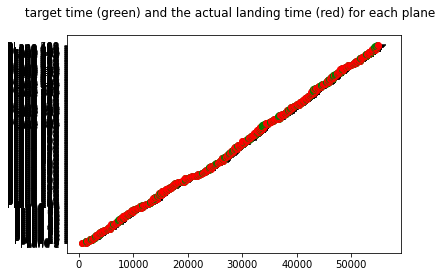

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

max___ = data[:][2]

max___ = int(max___.max())
for i in range(P):
  ax.hlines(y='PLane %d'%(i+1),xmin = E[i], xmax = L[i])
  plt.plot(T[i], i, 'go')
  plt.plot(x[i].solution_value(), i, 'ro')
#plt.xlim(95, max___ +5)
fig.suptitle(" target time (green) and the actual landing time (red) for each plane")
plt.show()